<a name="top"> <h1>5. Interpretability</h1> <a>

<p>Yelp Dataset- Stars Prediction<br />
<strong>Aprendizaje Autom&aacute;tico</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong></p>

<p>&nbsp;</p>

<p style="text-align:right">Antonio Nogués Podadera (<em>antonio.nogues@cunef.edu</em>)</p>
<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>

<hr style="border:1px solid gray">

### Estructura

[0. Introducción](#introduccion) 


[1. Importación de librerias y funciones](#librerias) 


[2. Importación de modelos](#modelos) 

[3. Transformación de variables](#transformacion) 

[4. Explicabilidad con Shap](#shap) 

- Explicabilidad local
- Explicabilidad global

   
[5. Explicabilidad con Sklearn](#sklearn) 

   
[6. Conclusiones Generales](#conclusiones)

<hr style="border:1px solid gray">

# <a name="introduccion"> 0. Introducción <a> 


La **interpretabilidad en el aprendizaje automático se refiere a la capacidad de un modelo de Machine Learning para ser comprendido por personas**. En muchas ocasiones un modelo de Machine Learning se ha tomado como una "caja negra", es decir, es difícil saber cómo funciona internamente y qué predicciones hace. Con la interpretabilidad logramos que el modelo sea más transparente y que podamos entender cómo funciona y qué predicciones hace.

Esto **incluye la capacidad de un modelo para explicar su funcionamiento y su lógica interna**, así como su capacidad para producir resultados y predicciones que sean interpretables por personas. 

La explicabilidad **es importante porque puede ayudar a asegurar que un modelo esté funcionando de manera correcta y predecible**, lo que puede ser especialmente importante en entornos críticos donde las decisiones tomadas por el modelo pueden tener impactos significativos.

En este documento **realizaremos un estudio acerca de la interpretabilidad del modelo**, para ello utilizaremos las libreria Shap y Sklearn.

# <a name="librerias"> 1. Importación de librerias y funciones <a> 


Importamos las librerias a utilizar:

In [2]:
# Import basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Import sklearn metrics

from sklearn import metrics
from sklearn.model_selection import cross_val_score


# Import sklearn models and pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

# Shap
import shap
shap.initjs()

Importamos las funciones:

In [3]:
# Import the functions to use in the notebook.

from aux_functions import load_model, save_model, get_feature_names

# Load the train dataset separated by other variables and target. 

x_train_all = pd.read_parquet("../data/processed/x_train_all.parquet").reset_index(drop=True)
y_train_all = pd.read_parquet("../data/processed/y_train_all.parquet").reset_index(drop=True)['stars']

# Load the test dataset separated by other variables and target. 

x_test = pd.read_parquet("../data/processed/x_test.parquet").reset_index(drop=True)
y_test = pd.read_parquet("../data/processed/y_test.parquet").reset_index(drop=True)['stars']

# <a name="modelos"> 2. Importación de modelos <a> 


En este apartado cargaremos el modelo optimizado, para posteriormente extraer el clasificador y preprocesado.

In [4]:
# Load the models. Both are the same, but with gridsearch the extraction of the preprocessor doesn't works.

clf = load_model('../models/search.pickle')
lightgbm_model_test = load_model('../models/lightgbm_model_test.pickle')

# Extract the preprocessor.

preprocessor = lightgbm_model_test.named_steps["preprocessor"]

# From the preprocessor, extract the feature names.

feature_names = preprocessor.feature_names_in_.tolist()

# <a name="transformacion"> 3. Transformación de variables <a> 

Dado que la libreria Shap trabaja con arrays, deberemos añadir el nombre de las columnas tras el preprocesado, para poder entender cuales son las que más tiene en cuenta el modelo.

In [5]:
# Insert into lists the names of the original variables 


short_cat_var = ['attributes_ByAppointmentOnly', 'attributes_BusinessAcceptsCreditCards', 'attributes_BikeParking', 'attributes_RestaurantsPriceRange2', 'attributes_CoatCheck', 'attributes_RestaurantsTakeOut',
'attributes_RestaurantsDelivery', 'attributes_Caters', 'attributes_WheelchairAccessible', 'attributes_HappyHour',
 'attributes_OutdoorSeating', 'attributes_HasTV', 'attributes_RestaurantsReservations', 'attributes_DogsAllowed', 'attributes_GoodForKids', 'attributes_RestaurantsTableService',
 'attributes_RestaurantsGoodForGroups', 'attributes_DriveThru', 'attributes_BusinessAcceptsBitcoin', 'attributes_GoodForDancing', 'attributes_AcceptsInsurance', 'attributes_BYOB',
 'attributes_Corkage', 'attributes_Open24Hours', 'attributes_RestaurantsCounterService', 'attributes_BusinessParkinggarage', 'attributes_BusinessParkingstreet', 'attributes_BusinessParkingvalidated',
 'attributes_BusinessParkinglot', 'attributes_BusinessParkingvalet', 'attributes_Ambience_romantic', 'attributes_Ambience_intimate', 'attributes_Ambience_touristy', 'attributes_Ambience_hipster',
 'attributes_Ambience_divey', 'attributes_Ambience_classy', 'attributes_Ambience_trendy', 'attributes_Ambience_upscale', 'attributes_Ambience_casual', 'attributes_Music_dj', 'attributes_Music_background_music',
 'attributes_Music_no_music', 'attributes_Music_jukebox', 'attributes_Music_live', 'attributes_Music_video', 'attributes_Music_karaoke', 'attributes_GoodForMeal_dessert',
 'attributes_GoodForMeal_latenight', 'attributes_GoodForMeal_lunch', 'attributes_GoodForMeal_dinner', 'attributes_GoodForMeal_brunch',
 'attributes_GoodForMeal_breakfast', 'attributes_BestNights_monday', 'attributes_BestNights_tuesday', 'attributes_BestNights_friday',
 'attributes_BestNights_wednesday', 'attributes_BestNights_thursday', 'attributes_BestNights_sunday', 'attributes_BestNights_saturday',
 'attributes_DietaryRestrictions_dairy-free', 'attributes_DietaryRestrictions_gluten-free', 'attributes_DietaryRestrictions_vegan',
 'attributes_DietaryRestrictions_kosher', 'attributes_DietaryRestrictions_halal', 'attributes_DietaryRestrictions_soy-free', 'attributes_DietaryRestrictions_vegetarian'
 ]

string_cat_var = ['attributes_WiFi','attributes_Alcohol','attributes_RestaurantsAttire', 'attributes_NoiseLevel','attributes_Smoking','attributes_BYOBCorkage','attributes_AgesAllowed']

long_cat_var = 'state'

num_var = ['review_count', 'total_hours_Monday', 'total_hours_Tuesday', 'total_hours_Wednesday', 'total_hours_Thursday', 'total_hours_Friday', 'total_hours_Saturday', 'total_hours_Sunday',
 'total_checkins']


 


In [6]:
# Obtain the name of the columns after the onehot encoding.

short_cat_names = lightgbm_model_test.named_steps["preprocessor"].named_transformers_['short_cat'].named_steps['onehot'].get_feature_names(input_features=short_cat_var).tolist()
string_cat_names = lightgbm_model_test.named_steps["preprocessor"].named_transformers_['string_cat'].named_steps['onehot'].get_feature_names(input_features=string_cat_var).tolist()

# Create a list concatenating all the feature names.

feature_names = short_cat_names + [long_cat_var] + string_cat_names + num_var

Realizamos la conversión de variables para poder utilizar la librería de Shap.

In [7]:
# Transform the data of xtest through the preprocessor and then assign the name of the columns using the feature names obtained before.

xtest = pd.DataFrame(clf.best_estimator_.named_steps['preprocessor'].transform(x_test), columns=feature_names)

# Extract the classifier.

model = clf.best_estimator_.named_steps['clasificador']

# Create an explainer variable to use it with Shap.

explainer = shap.TreeExplainer(clf.best_estimator_.named_steps['clasificador'])

# Adapt the xtest values for Shap.

shap_values = explainer.shap_values(xtest)

# <a name="shap"> 4. Explicabilidad con Shap <a> 

Una vez transformados los datos, podremos observar la explicabilidad global y local del modelo seleccionado.

- La explicabilidad local se refiere a la capacidad de un modelo de machine learning para explicar sus decisiones en un nivel detallado y preciso, en un contexto específico.

- La explicabilidad global, por otro lado, se refiere a la capacidad de un modelo para ser comprendido en una escala más amplia.

## Explicabilidad Global

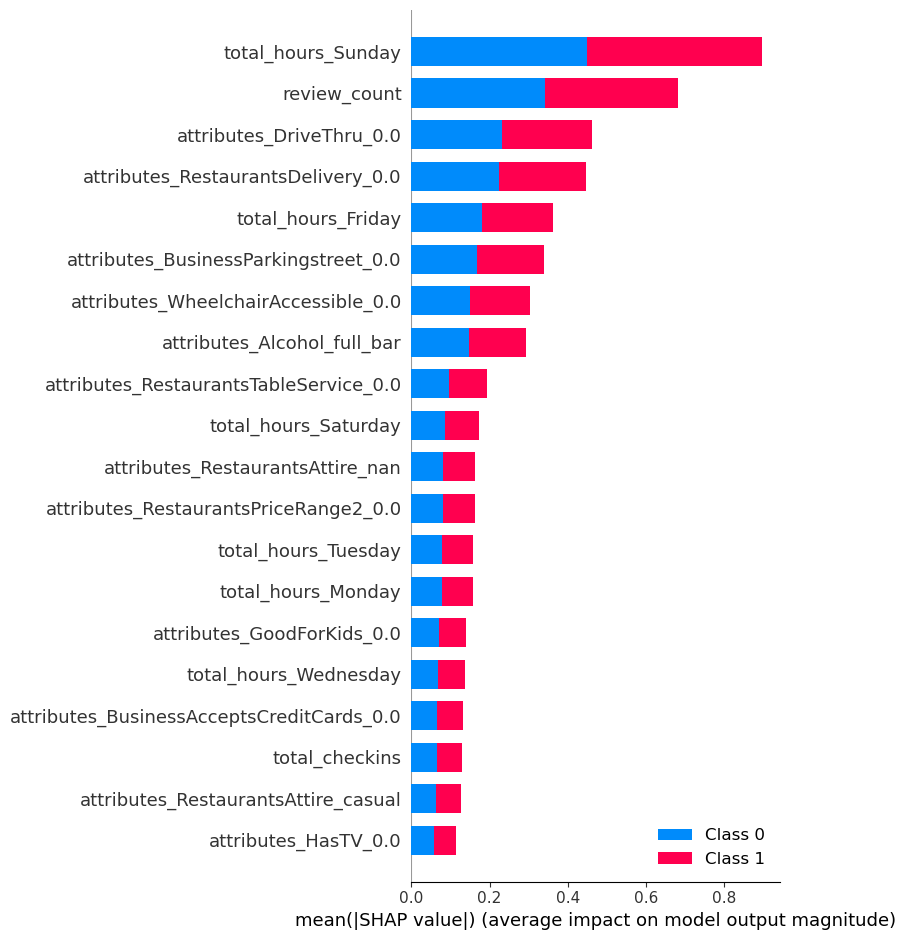

In [20]:
# Display the summary plot.

shap.summary_plot(shap_values, xtest, feature_names=feature_names)

En el gráfico superior podemos observar la importancia que ha asignado el modelo a las variables de forma global. En este caso las principales variables son:

   - **El total de horas que está abierto un restaurante los domingos**.
   
   - **El número de reviews**. 

   - **Servicio de recogida de comida en coche**

   - **Servicio de entrega a domicilio** 

En ambas variables afecta de la misma manera tanto para la clasificarlo en la clase 0 como en la clase 1.

## Explicabilidad local

### Caso de Restaurante con buena puntuación

In [71]:
# Display the local plot for a +4 stars observation.

shap.force_plot(explainer.expected_value[0], shap_values[0][0], xtest.iloc[0,:])

Hemos supuesto un caso en el que un restaurante es puntuado con una nota alta. En este caso se observa como la variable que hace referencia a la capacidad de aceptar pagos con tarjeta por parte del restaurante y el número total de horas que está abierto un sábado afectan negativamente, dado que no dispone de métodos de pago con tarjeta y el número de horas los sábados es bajo.

Sin embargo las variables que determinan en mayor medida que va a tener buena puntuación, son aquellas como `review_count` que tiene un número medio de valoraciones y que el restaurante dispone de envío a domicilio.  

### Caso de Restaurante con mala puntuación(<4 estrellas)

In [72]:
# Display the local plot for less than 4 stars observation.

shap.force_plot(explainer.expected_value[0], shap_values[0][5], xtest.iloc[5,:])

En este caso se ha supuesto un restaurante con una puntuación mala, es decir, inferior a las 4 estrellas. Las variables que han causado mayor efecto negativo sobre esta predicción, y por tanto, empujan al modelo a clasificarlo en esta categoría ha sido que no se determine el tipo de vestimenta con la que acudir, que el local haya puesto que hay un ambiente trendy y que no disponga de servicio DriveThru.

# <a name="sklearn"> 5. Explicabilidad con Sklearn <a> 

Dentro de la libreria Sklearn encontramos la **función feature_importances_**. 

Este atributo **es una matriz que contiene una puntuación para cada una de las características (o variables) utilizadas por el modelo**. Estas puntuaciones indican qué tan importantes son cada una de las características para el modelo y, por lo tanto, **pueden ser útiles para identificar qué características son más relevantes** para el rendimiento del modelo.

In [28]:
# Save into a variable the feature importances from the classifier.

importantVariables = clf.best_estimator_._final_estimator.feature_importances_

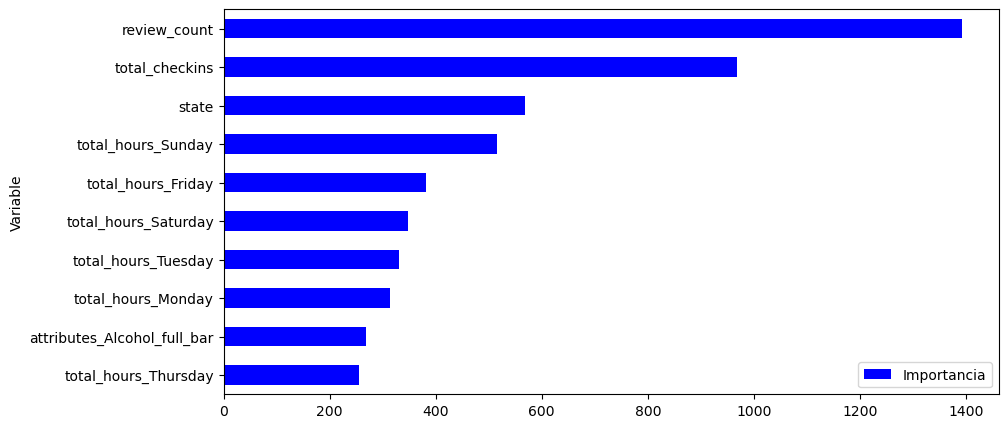

In [29]:
#Sort the variables 

importancia_variables = sorted(
                              list(zip(xtest.columns,
                                       importantVariables)),
    
    key=lambda tupla: tupla[1],
    reverse=True)

# Crate a DF with the importance of each variable.

importancia_variables = pd.DataFrame(importancia_variables)
importancia_variables.rename(columns={ 0: 'Variable',  1: 'Importancia'}, inplace=True)

# Plot the importance from the dataframe created.

importancia_variables.head(10).sort_values(by='Importancia', ascending=True).plot(kind='barh', x='Variable', y='Importancia', figsize=(10, 5), color='blue')

# Show the plot.

plt.show()


Las variables más importantes para el modelo son el número de reviews `reviews_count` y el total de checkins, coincidiendo la primera variable con los que ha obtenido la libreria Shap. Sorprende la segunda variable puesto que es una de las que ha clasificado la librería Shap como menos importante. 

# <a name="conclusiones"> 6. Conclusiones Generales <a> 

**- La puntuación que obtiene un restaurante es importante puesto que es la primera impresión y por lo que se guiarán muchos clientes y será determinante para que escojan dicho establecimiento.**

**- Gracias a la interpretabilidad del modelo local y global hemos podido obtener las variables que son más importantes para el modelo con la librería Shap, mientras que con Sklearn únicamente se ha podido averiguar la interpretabilidad global.**

**- Las variables más importantes para que el modelo sea capaz de clasificar un restaurante entre las dos clases (puntuación alta y puntuación baja) son el número de reviews previamente acumulados (`review_count`) y el número de horas que abre un local los domingos (`total_hours_Sunday`).**

[Ir arriba del documento](#top)